In [2]:
# system tools
import warnings
import json
import sys
import string
import ast

# data cleaning + analysis tools
import pandas as pd
import datetime as dt
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

#nlp tools
import lda #Latent Dirichlet Allocation (create topics)
import gensim
import spacy
from gensim import corpora, models #for constructing document term matrix
#from stop_words import get_stop_words
from gensim.models import Phrases
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.util import ngrams

#set notebook preferences
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.width', 1000)
warnings.filterwarnings('ignore')

%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


##  Import data frame from cleaning/preprocessing

In [152]:
data = pd.read_csv('data.csv')
data['final_mash'] = data['final_mash'].apply(lambda x:  ast.literal_eval(x))
data['mash'] = data['mash'].apply(lambda x:  ast.literal_eval(x))
data['common_bigrams'] = data['common_bigrams'].apply(lambda x:  ast.literal_eval(x))
data['token'] = data['token'].apply(lambda x:  ast.literal_eval(x))
data['lemma'] = data['lemma'].apply(lambda x:  ast.literal_eval(x))
data['pn'] = data['pn'].apply(lambda x:  ast.literal_eval(x))


In [14]:
data.mash_len.describe()

count    93772.000000
mean        15.941880
std         28.037314
min          1.000000
25%          3.000000
50%          8.000000
75%         18.000000
max       2682.000000
Name: mash_len, dtype: float64

## 1) Remove words at or below certain count

### count = 1

In [70]:
word_list = [y for x in list(data['mash']) for y in x]
counts = Counter(word_list)

In [71]:
count_df = pd.Series(counts, name = 'count') 
count_df.index.name = 'word'
count_df = count_df.reset_index()
count_df['count'].describe()

count    54183.000000
mean        25.364838
std        248.658395
min          1.000000
25%          1.000000
50%          1.000000
75%          4.000000
max      15231.000000
Name: count, dtype: float64

In [113]:
data1 = data.copy()
data1['mash'] = data1['mash'].apply(lambda x: [i for i in x if counts[i] > 10])
data1['final_mash'] = data1['mash'] + data1['common_bigrams']

In [114]:
data1['mash_len'] = data1['final_mash'].apply(len)
data1 = data1[data1['mash_len'] != 0]

In [115]:
data1.mash_len.describe()

count    92563.000000
mean        14.872476
std         26.004775
min          1.000000
25%          3.000000
50%          7.000000
75%         17.000000
max       2411.000000
Name: mash_len, dtype: float64

### count = 10

In [110]:
data10 = data.copy()
data10['mash'] = data10['mash'].apply(lambda x: [i for i in x if counts[i] > 10])
data10['final_mash'] = data10['mash'] + data10['common_bigrams']

In [112]:
data10 = data10[data10['mash_len'] != 0]
data10['mash_len'] = data10['final_mash'].apply(len)
data10.mash_len.describe()

count    93744.000000
mean        14.685111
std         25.893634
min          0.000000
25%          3.000000
50%          7.000000
75%         17.000000
max       2411.000000
Name: mash_len, dtype: float64

## 2) Remove proper names

### 2a) Using NLTK

In [80]:
data_pn_nltk = data.copy()

In [81]:
data_pn_nltk.head()

,index,Summary,city,month_year,sum_ed,token,lemma,mash,mash_len,bigrams,count_total,common_bigrams,final_mash
0,0,"We are working with an engineering firm on an upcoming project. They have asked us to gather maps for this project. Would you be able to assist me in gathering maps/records (as builds) for any underground water facilities you may have? Something just showing the route of the water lines would do.\n\n207th ST NE to 92nd Ave NE, Arlington, Cascade Surveying & Engineering \n\nI have attached the scope for your convenience. Please let me know if you have questions.",Arlington,2018-06,we are working with an engineering firm on an upcoming project they have asked us to gather maps for this project would you be able to assist me in gathering maps records as builds for any underground water facilities you may have something just showing the route of the water lines would do\n\nth st ne to nd ave ne cascade surveying engineering \n\ni have attached the scope for your convenience please let me know if you have questions,"[we, are, working, with, an, engineering, firm, on, an, upcoming, project, they, have, asked, us, to, gather, maps, for, this, project, would, you, be, able, to, assist, me, in, gathering, maps, records, as, builds, for, any, underground, water, facilities, you, may, have, something, just, showing, the, route, of, the, water, lines, would, do, th, st, ne, to, nd, ave, ne, cascade, surveying, engineering, i, have, attached, the, scope, for, your, convenience, please, let, me, know, if, you, have, questions]","[(we, PRP), (are, VBP), (working, VBG), (with, IN), (an, DT), (engineering, NN), (firm, NN), (on, IN), (an, DT), (upcoming, JJ), (project, NN), (they, PRP), (have, VBP), (asked, VBN), (us, PRP), (to, TO), (gather, VB), (maps, NNS), (for, IN), (this, DT), (project, NN), (would, MD), (you, PRP), (be, VB), (able, JJ), (to, TO), (assist, VB), (me, PRP), (in, IN), (gathering, VBG), (maps, NNS), (records, NNS), (as, IN), (builds, NNS), (for, IN), (any, DT), (underground, JJ), (water, NN), (facilities, NNS), (you, PRP), (may, MD), (have, VB), (something, NN), (just, RB), (showing, VBG), (the, DT), (route, NN), (of, IN), (the, DT), (water, NN), (lines, NNS), (would, MD), (do, VB), (th, VB), (st, VB), (ne, JJ), (to, TO), (nd, VB), (ave, VB), (ne, JJ), (cascade, NN), (surveying, VBG), (engineering, NN), (i, NN), (have, VBP), (attached, VBN), (the, DT), (scope, NN), (for, IN), (your, PRP$), (convenience, NN), (please, NN), (let, VB), (me, PRP), (know, VB), (if, IN), (you, PRP), (have, VBP), (...","[work, engineering, firm, upcoming, project, gather, map, project, assist, gather, map, build, underground, water, facility, something, show, route, water, line, cascade, survey, engineering, scope, convenience]",25,"['work_engineering', 'engineering_firm', 'firm_upcoming', 'upcoming_project', 'project_ask', 'ask_u', 'u_gather', 'gather_map', 'map_project', 'project_would', 'would_able', 'able_assist', 'assist_gather', 'gather_map', 'map_record', 'record_build', 'build_underground', 'underground_water', 'water_facility', 'facility_may', 'may_something', 'something_show', 'show_route', 'route_water', 'water_line', 'line_would', 'would_th', 'th_st', 'st_ne', 'ne_nd', 'nd_ave', 'ave_ne', 'ne_cascade', 'cascade_survey', 'survey_engineering', 'engineering_attach', 'attach_scope', 'scope_convenience', 'convenience_please', 'please_let', 'let_know', 'know_question']",61815,[],"[work, engineering, firm, upcoming, project, gather, map, project, assist, gather, map, build, underground, water, facility, something, show, route, water, line, cascade, survey, engineering, scope, convenience]"
1,1,"Need copies of contracts and all related documents pertaining to Topcub Aircraft property located at 17922 59th DR NE Arlington WA 98223 between Arlington Airport, Topcub Aircraft, City of Arlington, HCI Steel Buildings and PUD.",Arlington,2018-06,need copies of contracts and all related documents pertaining to topcub aircraft property locat

In [82]:
# two methods of identifying proper nouns, first tends to type II error (pn), second tends to type I error (pn2)

data_pn_nltk['pn'] = data_pn_nltk['lemma'].apply(lambda x: [i[0] for i in x if i[1] == 'NNP'])
data_pn_nltk['lemma2'] = data_pn_nltk['Summary'].apply(lambda x: nltk.tag.pos_tag(x.split()))
data_pn_nltk['pn2'] = data_pn_nltk['lemma2'].apply(lambda x: [i[0] for i in x if i[1] == 'NNP'])
data_pn_nltk['pn2'] = data_pn_nltk['pn2'].apply(lambda x: [i.lower() for i in x])
data_pn_nltk['final_mash2'] = data_pn_nltk.apply(lambda row: [i for i in row['final_mash'] if i not in row['pn2']], axis =1)
data_pn_nltk['final_mash'] = data_pn_nltk.apply(lambda row: [i for i in row['final_mash'] if i not in row['pn']], axis =1)
data_pn_nltk['mash_len'] = data_pn_nltk['final_mash'].apply(len)
data_pn_nltk['mash_len2'] = data_pn_nltk['final_mash2'].apply(len)

data_pn_nltk2 = data_pn_nltk[data_pn_nltk['mash_len2'] > 0]
data_pn_nltk = data_pn_nltk[data_pn_nltk['mash_len'] > 0]

In [83]:
data_pn_nltk2['mash_len2'].describe()

count    87278.000000
mean        12.408946
std         21.410852
min          1.000000
25%          2.000000
50%          6.000000
75%         14.000000
max       1643.000000
Name: mash_len2, dtype: float64

In [84]:
data_pn_nltk['mash_len'].describe()

count    93743.000000
mean        15.679624
std         27.586053
min          1.000000
25%          3.000000
50%          7.000000
75%         18.000000
max       2724.000000
Name: mash_len, dtype: float64

### 2b) Using spaCy

In [85]:
nlp = spacy.load('en_core_web_sm')
data_sp = data.copy()

In [86]:
data_sp['token_sp'] = data_sp['sum_ed'].apply(lambda x: nlp(x))
data_sp['token_sp2'] = data_sp['Summary'].apply(lambda x: nlp(x))
data_sp['pn'] = data_sp['token_sp'].apply(lambda x: [ i.lemma_ for i in x if i.tag_ == 'NNP'])
data_sp['pn2'] = data_sp['token_sp2'].apply(lambda x: [ i.lemma_ for i in x if i.tag_ == 'NNP'])
data_sp['final_mash2'] = data_sp.apply(lambda row: [i for i in row['final_mash'] if i not in row['pn2']], axis =1)
data_sp['final_mash'] = data_sp.apply(lambda row: [i for i in row['final_mash'] if i not in row['pn']], axis =1)


In [87]:
data_sp['mash_len'] = data_sp['final_mash'].apply(len)
data_sp['mash_len2'] = data_sp['final_mash2'].apply(len)
data_sp2 = data_sp[data_sp['mash_len2'] > 0]
data_sp = data_sp[data_sp['mash_len'] > 0]    

In [37]:
data_sp2['mash_len2'].describe()

count    90748.000000
mean        11.367303
std         20.714069
min          1.000000
25%          2.000000
50%          5.000000
75%         13.000000
max       1674.000000
Name: mash_len2, dtype: float64

In [38]:
data_sp['mash_len'].describe()

count    95292.000000
mean        15.747723
std         27.907075
min          1.000000
25%          3.000000
50%          7.000000
75%         18.000000
max       2746.000000
Name: mash_len, dtype: float64

In [32]:
data_sp.head()

,index,Summary,city,month_year,sum_ed,token,lemma,mash,mash_len,bigrams,common_bigrams,final_mash,token_sp,token_sp2,pn,pn2,final_mash2
0,0,"We are working with an engineering firm on an upcoming project. They have asked us to gather maps for this project. Would you be able to assist me in gathering maps/records (as builds) for any underground water facilities you may have? Something just showing the route of the water lines would do.\n\n207th ST NE to 92nd Ave NE, Arlington, Cascade Surveying & Engineering \n\nI have attached the scope for your convenience. Please let me know if you have questions.",Arlington,2018-06,we are working with an engineering firm on an upcoming project they have asked us to gather maps for this project would you be able to assist me in gathering maps records as builds for any underground water facilities you may have something just showing the route of the water lines would do\n\nth st ne to nd ave ne cascade surveying engineering \n\ni have attached the scope for your convenience please let me know if you have questions,"[we, are, working, with, an, engineering, firm, on, an, upcoming, project, they, have, asked, us, to, gather, maps, for, this, project, would, you, be, able, to, assist, me, in, gathering, maps, records, as, builds, for, any, underground, water, facilities, you, may, have, something, just, showing, the, route, of, the, water, lines, would, do, th, st, ne, to, nd, ave, ne, cascade, surveying, engineering, i, have, attached, the, scope, for, your, convenience, please, let, me, know, if, you, have, questions]","[('we', 'PRP'), ('are', 'VBP'), ('working', 'VBG'), ('with', 'IN'), ('an', 'DT'), ('engineering', 'NN'), ('firm', 'NN'), ('on', 'IN'), ('an', 'DT'), ('upcoming', 'JJ'), ('project', 'NN'), ('they', 'PRP'), ('have', 'VBP'), ('asked', 'VBN'), ('us', 'PRP'), ('to', 'TO'), ('gather', 'VB'), ('maps', 'NNS'), ('for', 'IN'), ('this', 'DT'), ('project', 'NN'), ('would', 'MD'), ('you', 'PRP'), ('be', 'VB'), ('able', 'JJ'), ('to', 'TO'), ('assist', 'VB'), ('me', 'PRP'), ('in', 'IN'), ('gathering', 'VBG'), ('maps', 'NNS'), ('records', 'NNS'), ('as', 'IN'), ('builds', 'NNS'), ('for', 'IN'), ('any', 'DT'), ('underground', 'JJ'), ('water', 'NN'), ('facilities', 'NNS'), ('you', 'PRP'), ('may', 'MD'), ('have', 'VB'), ('something', 'NN'), ('just', 'RB'), ('showing', 'VBG'), ('the', 'DT'), ('route', 'NN'), ('of', 'IN'), ('the', 'DT'), ('water', 'NN'), ('lines', 'NNS'), ('would', 'MD'), ('do', 'VB'), ('th', 'VB'), ('st', 'VB'), ('ne', 'JJ'), ('to', 'TO'), ('nd', 'VB'), ('ave', 'VB'), ('ne', 'JJ'), ('c...","[work, engineering, firm, upcoming, project, gather, map, project, assist, gather, map, build, underground, water, facility, something, show, route, water, line, cascade, survey, engineering, attach, scope, convenience]",26,"['work_engineering', 'engineering_firm', 'firm_upcoming', 'upcoming_project', 'project_ask', 'ask_u', 'u_gather', 'gather_map', 'map_project', 'project_would', 'would_able', 'able_assist', 'assist_gather', 'gather_map', 'map_record', 'record_build', 'build_underground', 'underground_water', 'water_facility', 'facility_may', 'may_something', 'something_show', 'show_route', 'route_water', 'water_line', 'line_would', 'would_th', 'th_st', 'st_ne', 'ne_nd', 'nd_ave', 'ave_ne', 'ne_cascade', 'cascade_survey', 'survey_engineering', 'engineering_attach', 'attach_scope', 'scope_convenience', 'convenience_please', 'please_let', 'let_know', 'know_question']",[],"[work, engineering, firm, upcoming, project, gather, map, project, assist, gather, map, build, underground, water, facility, something, show, route, water, line, cascade, survey, engineering, attach, scope, convenience]","(we, are, working, with, an, engineering, firm, on, an, upcoming, project, , they, have, asked, us, to, gather, maps, for, this, project, , would, you, be, able, to, assist, me, in, gathering, maps, records, as, builds, for, any, underground, water, facilities, you, may, have, , something, just, showing, the, 

In [88]:
data_sp2 = data_sp[data_sp['mash_len2'] > 0]
data_sp = data_sp[data_sp['mash_len'] > 0]

In [ ]:
data_sp2['mash_len2'].describe()

In [ ]:
data_sp['mash_len'].describe()

## 3) Drop cities with low (less than 4) average count - Asheville, Greensboro, Dayton, OKC

In [89]:
data_lg_cities = data.copy()

In [90]:
data_lg_cities = data_lg_cities[(data['city'] != 'Asheville') & (data['city'] != 'Greensboro') & 
                               (data['city'] != 'Dayton') & (data['city'] != 'OKC')]

## 4) Remove observations with small number of words in final mash 

### 4a) Greater than 2

In [91]:
data_4a = data.copy()
data_4a = data_4a[data_4a['mash_len'] > 2]

#### 4a.1) Model 1a

In [116]:
data_4a1 = data1.copy()
data_4a1 = data_4a1[data_4a1['mash_len'] > 2]

#### 4a.2) Model 1b

In [117]:
data_4a2 = data10.copy()
data_4a2 = data_4a2[data_4a2['mash_len'] > 2]

#### 4a.3) Model 2a

In [94]:
data_4a3 = data_sp2.copy()
data_4a3 = data_4a3[data_4a3['mash_len'] > 2]

#### 4a.4) Model 2b

In [95]:
data_4a4 = data_pn_nltk2.copy()
data_4a4 = data_4a4[data_4a4['mash_len'] > 2]

#### 4a.5) Model 3

In [96]:
data_4a5 = data_lg_cities.copy()
data_4a5 = data_4a5[data_4a5['mash_len'] > 2]

### 4b) Less than 3

In [99]:
data_4b = data.copy()
data_4b = data_4b[data_4b['mash_len'] > 3]

#### 4b.1) Model 1a

In [118]:
data_4b1 = data1.copy()
data_4b1 = data_4b1[data_4b1['mash_len'] > 3]

#### 4b.2) Model 1b

In [119]:
data_4b2 = data10.copy()
data_4b2 = data_4b2[data_4b2['mash_len'] > 3]

#### 4b.3) Model 2a

In [102]:
data_4b3 = data_sp2.copy()
data_4b3 = data_4b3[data_4b3['mash_len'] > 3]

#### 4b.4) Model 2b

In [103]:
data_4b4 = data_pn_nltk2.copy()
data_4b4 = data_4b4[data_4b4['mash_len'] > 3]

#### 4b.5) Model 3

In [104]:
data_4b5 = data_lg_cities.copy()
data_4b5 = data_4b5[data_4b5['mash_len'] > 3]

## Run all LDA models

In [105]:
# Model 1a - words count > 1

texts = list(data1['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data1 = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_data1"
lda_data1.save(model_name)
corpus_lda = lda_data1[corpus]
corpus_lda_list = list(corpus_lda)
topics = data1.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data1.csv"
topics.to_csv(file_name)



In [106]:
# Model 1b - words count > 10

texts = list(data10['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data10 = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_data10"
lda_data10.save(model_name)
corpus_lda = lda_data10[corpus]
corpus_lda_list = list(corpus_lda)
topics = data10.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data10.csv"
topics.to_csv(file_name)

# Model 2a

texts = list(data_pn_nltk2['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_nltk = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_data_nltk"
lda_data_nltk.save(model_name)
corpus_lda = lda_data_nltk[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_pn_nltk2.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_nltk.csv"
topics.to_csv(file_name)


# Model 2b

texts = list(data_sp2['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_sp = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_data_sp"
lda_data_sp.save(model_name)
corpus_lda = lda_data_nltk[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_sp2.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_sp.csv"
topics.to_csv(file_name)


KeyboardInterrupt: 

In [120]:
# Model 3

texts = list(data_lg_cities['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_lg_cities = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_data_lg_cities"
lda_data_lg_cities.save(model_name)
corpus_lda = lda_data_lg_cities[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_lg_cities.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_lg_cities.csv"
topics.to_csv(file_name)


# Model 4a

texts = list(data_4a['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_4a = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_data_4a"
lda_data_4a.save(model_name)
corpus_lda = lda_data_4a[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_4a.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_4a.csv"
topics.to_csv(file_name)

# Model 4a1

texts = list(data_4a1['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_4a1 = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_data_4a1"
lda_data_4a1.save(model_name)
corpus_lda = lda_data_4a1[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_4a1.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_4a1.csv"
topics.to_csv(file_name)

# Model 4a2

texts = list(data_4a2['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_4a2 = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_data_42a"
lda_data_4a2.save(model_name)
corpus_lda = lda_data_4a2[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_4a2.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_4a2.csv"
topics.to_csv(file_name)

# Model 4a3

texts = list(data_4a3['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_4a3 = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_data_4a3"
lda_data_4a3.save(model_name)
corpus_lda = lda_data_4a3[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_4a3.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_4a3.csv"
topics.to_csv(file_name)

# Model 4a4

texts = list(data_4a4['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_4a4 = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_data_4a4"
lda_data_4a4.save(model_name)
corpus_lda = lda_data_4a4[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_4a4.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_4a4.csv"
topics.to_csv(file_name)

# Model 4a5

texts = list(data_4a5['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_4a5 = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_data_4a5"
lda_data_4a5.save(model_name)
corpus_lda = lda_data_4a5[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_4a5.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_4a5.csv"
topics.to_csv(file_name)

# Model 4b

texts = list(data_4b['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_4b = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_data_4b"
lda_data_4b.save(model_name)
corpus_lda = lda_data_4b[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_4b.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_4b.csv"
topics.to_csv(file_name)

# Model 4b1

texts = list(data_4b1['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_4b1 = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_data_4b1"
lda_data_4b1.save(model_name)
corpus_lda = lda_data_4b1[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_4b1.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_4b1.csv"
topics.to_csv(file_name)

# Model 4b2

texts = list(data_4b2['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_4b2 = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_data_4b2"
lda_data_4b2.save(model_name)
corpus_lda = lda_data_4b2[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_4b2.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_4b2.csv"
topics.to_csv(file_name)

# Model 4b3

texts = list(data_4b3['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_4b3 = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_data_4b3"
lda_data_4b3.save(model_name)
corpus_lda = lda_data_4b3[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_4b3.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_4b3.csv"
topics.to_csv(file_name)

# Model 4b4

texts = list(data_4b4['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_4b4 = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_data_4b4"
lda_data_4b4.save(model_name)
corpus_lda = lda_data_4b4[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_4b4.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_4b4.csv"
topics.to_csv(file_name)

# Model 4b5

texts = list(data_4b5['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_4b5 = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_data_4b5"
lda_data_4b5.save(model_name)
corpus_lda = lda_data_4b5[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_4b5.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_4b5.csv"
topics.to_csv(file_name)

KeyboardInterrupt: 

## Model 5 - Proper Nouns with low count 

### 5a) (count = 1)

In [67]:
data_pn = data.copy()

In [68]:
# Create proper noun counter

pn_list = [y for x in list(data_pn['pn']) for y in x]
pn_counts = Counter(pn_list)

In [69]:
# Create proper noun counter

fm_list = [y for x in list(data_pn['final_mash']) for y in x]
fm_counts = Counter(fm_list)

In [46]:
words = list(fm_counts.keys())
cnt = list(fm_counts.values())
fm_count_df = pd.DataFrame({'word': words, 'cnt': cnt})

In [32]:
words = list(pn_counts.keys())
cnt = list(pn_counts.values())
pn_count_df = pd.DataFrame({'word': words, 'cnt': cnt})

In [61]:
fm_count_df.cnt.describe()

count    40198.000000
mean        36.609060
std        298.085926
min          1.000000
25%          1.000000
50%          2.000000
75%          6.000000
max      16184.000000
Name: cnt, dtype: float64

In [85]:
pn_count_df.cnt.describe()

count    44368.000000
mean        15.451925
std        187.268373
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max      14872.000000
Name: cnt, dtype: float64

In [34]:
pn_count_df.sort_values(by = ['cnt'], inplace = True)

In [74]:
data_pn['pn1'] = data_pn['pn'].apply(lambda x: [i for i in x if 0 < fm_counts[i] < 2])

In [63]:
data_pn['pn1_len'] = data_pn['pn1'].apply(len)

In [75]:
data_pn['final_mash'] = data_pn.apply(lambda row: [i for i in row['final_mash'] if i not in row['pn1']], axis =1)
data_pn['mash_len'] = data_pn['final_mash'].apply(len)
data_pn = data_pn[data_pn['mash_len'] > 0]

In [76]:
data_pn[:20]

,index,Summary,city,month_year,token_sp,pn,sum_ed,token,lemma,mash,mash_len,bigrams,common_bigrams,final_mash,ave,pn1
0,0,We are working with an engineering firm on an upcoming project They have asked us to gather maps for this project Would you be able to assist me in gathering mapsrecords as builds for any underground water facilities you may have Something just showing the route of the water lines would do\n\nth ST NE to nd Ave NE Arlington Cascade Surveying Engineering \n\nI have attached the scope for your convenience Please let me know if you have questions,Arlington,2018-06,We are working with an engineering firm on an upcoming project They have asked us to gather maps for this project Would you be able to assist me in gathering mapsrecords as builds for any underground water facilities you may have Something just showing the route of the water lines would do\n\nth ST NE to nd Ave NE Arlington Cascade Surveying Engineering \n\nI have attached the scope for your convenience Please let me know if you have questions,"[ave, ne, arlington, cascade, surveying, engineering]",we are working with an engineering firm on an upcoming project they have asked us to gather maps for this project would you be able to assist me in gathering mapsrecords as builds for any underground water facilities you may have something just showing the route of the water lines would do\n\nth st ne to nd ave ne arlington cascade surveying engineering \n\ni have attached the scope for your convenience please let me know if you have questions,"[we, are, working, with, an, engineering, firm, on, an, upcoming, project, they, have, asked, us, to, gather, maps, for, this, project, would, you, be, able, to, assist, me, in, gathering, mapsrecords, as, builds, for, any, underground, water, facilities, you, may, have, something, just, showing, the, route, of, the, water, lines, would, do, th, st, ne, to, nd, ave, ne, arlington, cascade, surveying, engineering, i, have, attached, the, scope, for, your, convenience, please, let, me, know, if, you, have, questions]","[(we, PRP), (are, VBP), (working, VBG), (with, IN), (an, DT), (engineering, NN), (firm, NN), (on, IN), (an, DT), (upcoming, JJ), (project, NN), (they, PRP), (have, VBP), (asked, VBN), (us, PRP), (to, TO), (gather, VB), (maps, NNS), (for, IN), (this, DT), (project, NN), (would, MD), (you, PRP), (be, VB), (able, JJ), (to, TO), (assist, VB), (me, PRP), (in, IN), (gathering, VBG), (mapsrecords, NNS), (as, IN), (builds, NNS), (for, IN), (any, DT), (underground, JJ), (water, NN), (facilities, NNS), (you, PRP), (may, MD), (have, VB), (something, NN), (just, RB), (showing, VBG), (the, DT), (route, NN), (of, IN), (the, DT), (water, NN), (lines, NNS), (would, MD), (do, VB), (th, VB), (st, VB), (ne, JJ), (to, TO), (nd, VB), (ave, VB), (ne, JJ), (arlington, NN), (cascade, NN), (surveying, VBG), (engineering, NN), (i, NN), (have, VBP), (attached, VBN), (the, DT), (scope, NN), (for, IN), (your, PRP$), (convenience, NN), (please, NN), (let, VB), (me, PRP), (know, VB), (if, IN), (you, PRP), (have,...","[work, engineering, firm, upcoming, project, gather, map, project, assist, gather, mapsrecords, build, underground, water, facility, something, show, route, water, line, arlington, cascade, survey, engineering, scope, convenience]",26,"['work_engineering', 'engineering_firm', 'firm_upcoming', 'upcoming_project', 'project_ask', 'ask_u', 'u_gather', 'gather_map', 'map_project', 'project_would', 'would_able', 'able_assist', 'assist_gather', 'gather_mapsrecords', 'mapsrecords_build', 'build_underground', 'underground_water', 'water_facility', 'facility_may', 'may_something', 'something_show', 'show_route', 'route_water', 'water_line', 'line_would', 'would_th', 'th_st', 'st_ne', 'ne_nd', 'nd_ave', 'ave_ne', 'ne_arlington', 'arlington_cascade', 'cascade_survey', 'survey_engineering', 'engineering_attach', 'attach_scope', 'scope_convenience', 'convenience_please', 'please_let', 'let_know', 'know_question']",[],"[work, engineeri

### 5a) (count < 4)

In [77]:
data_pn4 = data.copy()

In [119]:
data_pn4['pn4'] = data_pn4['pn'].apply(lambda x: [i for i in x if 0 < fm_counts[i] < 4])

In [81]:
data_pn4['final_mash'] = data_pn4.apply(lambda row: [i for i in row['final_mash'] if i not in row['pn4']], axis =1)
data_pn4['mash_len'] = data_pn4['final_mash'].apply(len)
data_pn4 = data_pn4[data_pn4['mash_len'] > 0]

In [106]:
data_pn4.shape

(93148, 16)

In [117]:
data_pn4_3 = data_pn4[data_pn4['mash_len'] > 3]

In [118]:
data_pn4_3.shape

(66070, 16)

In [120]:
data_pn4['count_total'] = data_pn4['final_mash'].apply(lambda x: sum(fm_counts[i] for i in x))

## 6) Either short length or high count

In [87]:
data_c = data.copy()

In [88]:
data_c.shape

(93772, 16)

In [89]:
data_c['count_total'] = data_c['final_mash'].apply(lambda x: sum(fm_counts[i] for i in x))

In [90]:
data_c.count_total.describe()

count    9.377200e+04
mean     3.866510e+04
std      5.727614e+04
min      1.000000e+00
25%      5.847000e+03
50%      2.019350e+04
75%      4.343200e+04
max      2.299756e+06
Name: count_total, dtype: float64

In [91]:
data_c.mash_len.describe()

count    93772.000000
mean        15.941880
std         28.037314
min          1.000000
25%          3.000000
50%          8.000000
75%         18.000000
max       2682.000000
Name: mash_len, dtype: float64

In [93]:
data_c = data_c[(data_c['mash_len'] > 2) | (data_c['count_total'] > 10)]

In [96]:
data_c20 = data_c[(data_c['mash_len'] > 2) | (data_c['count_total'] > 20)]

In [100]:
data_c3 = data_c[(data_c['mash_len'] > 3) | (data_c['count_total'] > 10)]

In [102]:
data_c20_3 = data_c[(data_c['mash_len'] > 3) | (data_c['count_total'] > 20)]

In [110]:
data_c100_3 = data_c[(data_c['mash_len'] > 3) | (data_c['count_total'] > 100)]

In [112]:
data_c2000_3 = data_c[(data_c['mash_len'] > 3) | (data_c['count_total'] > 2000)]

In [121]:
data_c1000_3_count4 = data_pn4[(data_pn4['mash_len'] > 3) | (data_pn4['count_total'] > 1000)]

In [123]:
data_c1000_3_count4.mash_len.describe()

count    86381.000000
mean        16.661523
std         28.273993
min          1.000000
25%          4.000000
50%          8.000000
75%         19.000000
max       2553.000000
Name: mash_len, dtype: float64

In [108]:
### Run Models

## 5a

texts = list(data_pn['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_pn = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_data_pn"
lda_data_pn.save(model_name)
corpus_lda = lda_data_pn[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_pn.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_pn.csv"
topics.to_csv(file_name)

## 5b

texts = list(data_pn4['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_pn4 = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_data_pn4"
lda_data_pn4.save(model_name)
corpus_lda = lda_data_pn4[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_pn4.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_pn4.csv"
topics.to_csv(file_name)


## 6a
texts = list(data_c['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_c = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_data_c"
lda_data_c.save(model_name)
corpus_lda = lda_data_c[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_c.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_c.csv"
topics.to_csv(file_name)


## 6b

texts = list(data_c20['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_c20 = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_data_c20"
lda_data_c20.save(model_name)
corpus_lda = lda_data_c20[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_c20.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_c20.csv"
topics.to_csv(file_name)


## 6c

texts = list(data_c3['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_c3 = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_data_c3"
lda_data_c3.save(model_name)
corpus_lda = lda_data_c3[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_c3.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_c3.csv"
topics.to_csv(file_name)


## 6d

texts = list(data_c20_3['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_c20_3 = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_data_c20_3"
lda_data_c20_3.save(model_name)
corpus_lda = lda_data_c20_3[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_c20_3.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_c20_3.csv"
topics.to_csv(file_name)


In [111]:
texts = list(data_c100_3['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_c100_3 = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_data_c100_3"
lda_data_c100_3.save(model_name)
corpus_lda = lda_data_c100_3[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_c100_3.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_c100_3.csv"
topics.to_csv(file_name)

In [113]:
texts = list(data_c2000_3['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_c2000_3 = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_data_c2000_3"
lda_data_c2000_3.save(model_name)
corpus_lda = lda_data_c2000_3[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_c2000_3.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_c2000_3.csv"
topics.to_csv(file_name)

In [115]:
lda_data_c2000_3 = gensim.models.ldamodel.LdaModel.load('lda_data_c2000_3')
lda_data_c2000_3.show_topics(num_topics=60, formatted=False)

[(0,
  [('location', 0.09353494),
   ('drive', 0.08829514),
   ('home', 0.06857166),
   ('place', 0.05400834),
   ('view', 0.031239841),
   ('try', 0.031040756),
   ('insured', 0.029058915),
   ('park', 0.02699882),
   ('administration', 0.02157155),
   ('avondale', 0.019310147)]),
 (1,
  [('help', 0.08086872),
   ('several', 0.044407763),
   ('tenant', 0.040521346),
   ('tell', 0.040185418),
   ('housing', 0.03772598),
   ('people', 0.033967048),
   ('short', 0.030789105),
   ('narrative', 0.024729665),
   ('dont', 0.02233389),
   ('daniel', 0.021673545)]),
 (2,
  [('plan', 0.09680636),
   ('locate', 0.058132455),
   ('permit', 0.05701802),
   ('property', 0.052246254),
   ('parcel', 0.052014254),
   ('building', 0.04471978),
   ('site', 0.03542623),
   ('property_locate', 0.0310093),
   ('build', 0.028195241),
   ('certificate', 0.026865209)]),
 (3,
  [('center', 0.10677224),
   ('entity', 0.07329042),
   ('believe', 0.067549035),
   ('dept', 0.04189583),
   ('fill', 0.035377637),
  

## 7) Calculate avg count per word

In [156]:
data_c1000_3 = data_c[(data_c['mash_len'] > 3) | (data_c['count_total'] > 1000)]

In [157]:
data_c1000_3['avg_count'] = data_c1000_3['count_total']/ data_c1000_3['mash_len']

In [158]:
data_c1000_3.avg_count.describe()

count    86625.000000
mean      2938.751519
std       2119.951414
min          1.250000
25%       1500.942857
50%       2440.000000
75%       3780.000000
max      16184.000000
Name: avg_count, dtype: float64

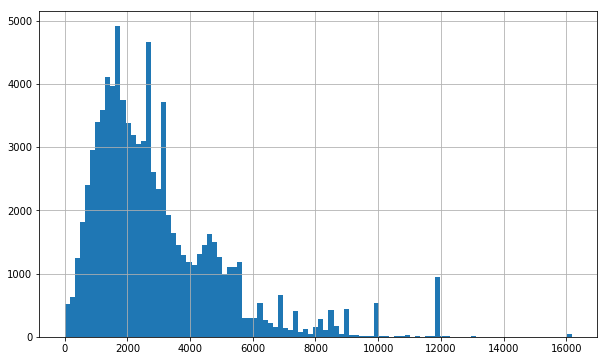

In [161]:
data_c1000_3.avg_count.hist(bins = 100)
plt.show()

## 8) Remove all words on surnames or first names list

In [155]:
def name_list(st, end):
    names = set()
    for yr in range(st, end+1):
        fp = '../data/names/yob{}.txt'.format(yr)
        df = pd.read_table(fp, sep = ',', names = ['name', 'sex', 'count'])
        df['name'] = df['name'].str.lower()
        names |= set(df['name'])
    
    return list(names)
        

In [127]:
df = pd.read_table('../data/names/yob2000.txt', sep = ',', names = ['name', 'sex', 'count'])

In [148]:
names = name_list(1950,2017)

In [145]:
last_names = pd.read_csv('../data/names/surnames.csv')
last_names['name'] = last_names['name'].str.lower()
ln = list(last_names['name'])

In [149]:
all_names = names + ln

In [153]:
data8 = data.copy()

In [154]:
data8['final_mash'] = data8['final_mash'].apply(lambda x: [i for i in x if i not in all_names])

KeyboardInterrupt: 

In [ ]:
data8.to_csv('data8.csv')